In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.impute import SimpleImputer
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm import tqdm_notebook

In [2]:
train_path = 'train.csv'
test_path = 'test.csv'
sample_path = 'sample_submission.csv'

raw_train = pd.read_csv(train_path, index_col='id')
raw_test = pd.read_csv(test_path, index_col='id')
raw_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [6]:
raw_train.shape, raw_test.shape

((600000, 24), (400000, 23))

In [15]:
#column의 수가 다른 두 df을 concat하면 차이나는 column들은 모두 NAN으로 채워진다.
#sort : column 이름의 사전순서
all_data = pd.concat([raw_train, raw_test],sort = False).drop(columns = 'target')

In [17]:
#iloc : index만, loc : index 및 column이름 둘다 가능
all_data.loc[600000-1:,:]
all_data.shape

(1000000, 23)

In [56]:
cate_cols = all_data.select_dtypes(include = ['object']).columns
cate_cols

Index(['bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5',
       'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
       'ord_5'],
      dtype='object')

In [26]:
col = cate_cols[0]
train_values = set(raw_train[col].unique())
test_values = set(raw_test[col].unique())

In [27]:
train_values, test_values

({'F', 'T', nan}, {'F', 'T', nan})

In [28]:
train_values ^ test_values

set()

In [51]:
all_data.loc[all_data['nom_6'].isin(['a885aacec']) == True,'nom_6'] = 'xor'

In [53]:
all_data.loc[all_data['nom_6'].isin(['xor']) == True,'nom_6']

id
943202    xor
Name: nom_6, dtype: object

In [57]:
for col in cate_cols:
    train_values = set(raw_train[col].unique())
    test_values = set(raw_test[col].unique())
    xor_values = train_values ^ test_values
    
    if xor_values:
        print(f'Replace {len(xor_values)} in {col} column')
        print('They are: ', xor_values)
        print()
        all_data.loc[all_data[col].isin(xor_values),col] = 'xor'

Replace 1 in nom_5 column
They are:  {'b3ad70fcb'}

Replace 4 in nom_6 column
They are:  {'f0732a795', '3a121fefb', 'a885aacec', 'ee6983c6d'}

Replace 2 in nom_9 column
They are:  {'1065f10dd', '3d19cd31d'}



In [62]:
all_data['ord_1'].unique()

array(['Contributor', 'Grandmaster', nan, 'Novice', 'Expert', 'Master'],
      dtype=object)

In [63]:
map_ord1 = {'Novice' : 1, 'Contributor' :2, 'Expert' : 3, 'Master' : 4, 'Grandmaster' : 5}
all_data.ord_1 = all_data.ord_1.map(map_ord1)

In [70]:
all_data['ord_1'].head()

id
0    2.0
1    5.0
2    NaN
3    1.0
4    5.0
Name: ord_1, dtype: float64

In [66]:
all_data['ord_2'].unique()

array(['Hot', 'Warm', 'Freezing', 'Lava Hot', 'Cold', 'Boiling Hot', nan],
      dtype=object)

In [67]:
map_ord2 = {'Freezing' : 1, 'Cold' : 2, 'Warm' : 3, 'Hot' : 4, 'Boiling Hot' : 5, 'Lava Hot' : 6}
all_data.ord_2 = all_data.ord_2.map(map_ord2)

In [69]:
all_data.ord_2.head()

id
0    4.0
1    3.0
2    1.0
3    6.0
4    2.0
Name: ord_2, dtype: float64

In [71]:
all_data['ord_3'].unique()

array(['c', 'e', 'n', 'a', 'h', 'b', 'd', 'k', 'g', 'o', 'i', 'm', nan,
       'f', 'l', 'j'], dtype=object)

In [72]:
all_data['ord_3'] = all_data.ord_3.map(ord, na_action = 'ignore')

In [74]:
all_data['ord_3']

id
0          99.0
1         101.0
2         110.0
3          97.0
4         104.0
          ...  
999995    110.0
999996    110.0
999997    109.0
999998    104.0
999999     99.0
Name: ord_3, Length: 1000000, dtype: float64

In [77]:
map_ord3 = {key:value for value,key in enumerate(sorted(all_data.ord_3.dropna().unique()))}

In [78]:
map_ord3

{97.0: 0,
 98.0: 1,
 99.0: 2,
 100.0: 3,
 101.0: 4,
 102.0: 5,
 103.0: 6,
 104.0: 7,
 105.0: 8,
 106.0: 9,
 107.0: 10,
 108.0: 11,
 109.0: 12,
 110.0: 13,
 111.0: 14}

In [80]:
all_data.ord_3 = all_data.ord_3.map(map_ord3)
all_data.ord_3.head()

id
0     2.0
1     4.0
2    13.0
3     0.0
4     7.0
Name: ord_3, dtype: float64

In [75]:
all_data['ord_4'].unique()

array(['U', 'X', 'P', 'C', 'Q', 'R', 'Y', 'N', 'I', 'O', 'M', 'E', 'V',
       'K', 'G', 'B', 'H', nan, 'T', 'W', 'A', 'F', 'D', 'S', 'J', 'L',
       'Z'], dtype=object)

In [82]:
all_data['ord_4'] = all_data.ord_4.map(ord, na_action = 'ignore')
all_data.ord_4.head()

id
0    85.0
1    88.0
2    80.0
3    67.0
4    67.0
Name: ord_4, dtype: float64

In [84]:
map_ord4 = {key:value for value,key in enumerate(sorted(all_data.ord_4.dropna().unique()))}
all_data.ord_4 = all_data.ord_4.map(map_ord4)
all_data.ord_4.head()

id
0    20.0
1    23.0
2    15.0
3     2.0
4     2.0
Name: ord_4, dtype: float64

In [87]:
all_data['ord_5_1'] = all_data.ord_5.map(lambda string:ord(string[0]), na_action = 'ignore')
all_data['ord_5_2'] = all_data.ord_5.map(lambda string:ord(string[1]), na_action = 'ignore')
map_ord5 = {key:value for value,key in enumerate(sorted(all_data.ord_5.dropna().unique()))}
all_data.ord_5 = all_data.ord_5.map(map_ord5)

In [91]:
all_data.ord_5.head()

id
0     56.0
1    150.0
2    105.0
3      NaN
4     50.0
Name: ord_5, dtype: float64

In [92]:
all_data.ord_5_1.head()

id
0     80.0
1    112.0
2    101.0
3      NaN
4     79.0
Name: ord_5_1, dtype: float64

In [93]:
all_data.ord_5_2.head()

id
0    119.0
1     69.0
2     78.0
3      NaN
4     90.0
Name: ord_5_2, dtype: float64

In [95]:
all_data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,ord_5_1,ord_5_2
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,3.0,2.0,4.0,2.0,20.0,56.0,6.0,3.0,80.0,119.0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,3.0,5.0,3.0,4.0,23.0,150.0,7.0,7.0,112.0,69.0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,3.0,NaN,1.0,13.0,15.0,105.0,5.0,9.0,101.0,78.0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,1.0,1.0,6.0,0.0,2.0,NaN,3.0,3.0,NaN,NaN
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,3.0,5.0,2.0,7.0,2.0,50.0,5.0,12.0,79.0,90.0


In [97]:
num_cols = all_data.select_dtypes(exclude = ['object']).columns.drop(['bin_0', 'bin_1', 'bin_2'])
cate_cols = all_data.columns.drop(num_cols)

In [98]:
num_cols, cate_cols

(Index(['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
        'ord_5_1', 'ord_5_2'],
       dtype='object'),
 Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
        'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'],
       dtype='object'))

In [99]:
missing_cols = [col for col in num_cols if any(all_data[col].isnull())]
missing_cols

['ord_0',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5',
 'day',
 'month',
 'ord_5_1',
 'ord_5_2']

In [100]:
for col in missing_cols:
    all_data[col + ' : missing'] = all_data[col].isnull().astype(int)

In [109]:
all_data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,ord_0 : missing,ord_1 : missing,ord_2 : missing,ord_3 : missing,ord_4 : missing,ord_5 : missing,day : missing,month : missing,ord_5_1 : missing,ord_5_2 : missing
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,0,1,0,0,0,0,0,0,0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,0,0,0,0,0,1,0,0,1,1
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,0,0,0,0,0,0,0,0,0,0


In [108]:
all_data.loc[all_data.ord_1.isna(), 'ord_1 : missing']

id
2         1
187       1
195       1
211       1
276       1
         ..
999750    1
999823    1
999917    1
999935    1
999948    1
Name: ord_1 : missing, Length: 30208, dtype: int32

In [110]:
time_cols = ['day', 'month']
for col in time_cols:
    all_data[col+'_sin'] = np.sin(2 * np.pi * all_data[col] / 7)
    all_data[col+'_cos'] = np.cos(2 * np.pi * all_data[col] / 12)
all_data = all_data.drop(columns = time_cols)

In [111]:
all_data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,ord_4 : missing,ord_5 : missing,day : missing,month : missing,ord_5_1 : missing,ord_5_2 : missing,day_sin,day_cos,month_sin,month_cos
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,0,0,0,0,0,0,-7.818315e-01,-1.000000e+00,4.338837e-01,6.123234e-17
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,0,0,0,0,0,0,-2.449294e-16,-8.660254e-01,-2.449294e-16,-8.660254e-01
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,0,0,0,0,0,0,-9.749279e-01,-8.660254e-01,9.749279e-01,-1.836970e-16
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,0,1,0,0,1,1,4.338837e-01,6.123234e-17,4.338837e-01,6.123234e-17
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,0,0,0,0,0,0,-9.749279e-01,-8.660254e-01,-9.749279e-01,1.000000e+00


In [124]:
retain_cols = [f'ord_{i}' for i in range(6)] + ['day_sin', 'day_cos', 'month_sin', 'month_cos']
OH_cols = all_data.columns#.drop(retain_cols)

In [125]:
retain_cols, OH_cols

(['ord_0',
  'ord_1',
  'ord_2',
  'ord_3',
  'ord_4',
  'ord_5',
  'day_sin',
  'day_cos',
  'month_sin',
  'month_cos'],
 Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
        'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
        'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'ord_5_1', 'ord_5_2',
        'ord_0 : missing', 'ord_1 : missing', 'ord_2 : missing',
        'ord_3 : missing', 'ord_4 : missing', 'ord_5 : missing',
        'day : missing', 'month : missing', 'ord_5_1 : missing',
        'ord_5_2 : missing', 'day_sin', 'day_cos', 'month_sin', 'month_cos'],
       dtype='object'))

In [126]:
len(OH_cols)

37

In [127]:
all_OH = pd.get_dummies(all_data,
                        columns = OH_cols,
                        dummy_na=True,
                        sparse=True,
                        drop_first=True).sparse.to_coo()

In [133]:
imputer = SimpleImputer() # strategy = 'mean' : default
retain_all = pd.DataFrame(imputer.fit_transform(all_data[retain_cols]), columns = retain_cols)
retain_all

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,3.0,2.000000,4.000000,2.0,20.0,56.000000,-7.818315e-01,-1.000000e+00,4.338837e-01,6.123234e-17
1,3.0,5.000000,3.000000,4.0,23.0,150.000000,-2.449294e-16,-8.660254e-01,-2.449294e-16,-8.660254e-01
2,3.0,2.720606,1.000000,13.0,15.0,105.000000,-9.749279e-01,-8.660254e-01,9.749279e-01,-1.836970e-16
3,1.0,1.000000,6.000000,0.0,2.0,91.013228,4.338837e-01,6.123234e-17,4.338837e-01,6.123234e-17
4,3.0,5.000000,2.000000,7.0,2.0,50.000000,-9.749279e-01,-8.660254e-01,-9.749279e-01,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...
999995,2.0,3.000000,3.000000,13.0,17.0,103.000000,9.749279e-01,5.000000e-01,-9.749279e-01,1.000000e+00
999996,1.0,2.000000,3.083473,13.0,23.0,79.000000,7.818315e-01,8.660254e-01,-9.749279e-01,-8.660254e-01
999997,1.0,5.000000,5.000000,12.0,15.0,73.000000,7.818315e-01,8.660254e-01,-7.818315e-01,-1.000000e+00
999998,3.0,1.000000,6.000000,7.0,11.0,11.000000,9.749279e-01,5.000000e-01,-4.338837e-01,8.660254e-01


In [136]:
retain_all = retain_all/retain_all.max()
retain_all

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,1.000000,0.400000,0.666667,0.142857,0.80,0.296296,-8.019377e-01,-1.154701e+00,4.450419e-01,6.123234e-17
1,1.000000,1.000000,0.500000,0.285714,0.92,0.793651,-2.512282e-16,-1.000000e+00,-2.512282e-16,-8.660254e-01
2,1.000000,0.544121,0.166667,0.928571,0.60,0.555556,-1.000000e+00,-1.000000e+00,1.000000e+00,-1.836970e-16
3,0.333333,0.200000,1.000000,0.000000,0.08,0.481551,4.450419e-01,7.070502e-17,4.450419e-01,6.123234e-17
4,1.000000,1.000000,0.333333,0.500000,0.08,0.264550,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...
999995,0.666667,0.600000,0.500000,0.928571,0.68,0.544974,1.000000e+00,5.773503e-01,-1.000000e+00,1.000000e+00
999996,0.333333,0.400000,0.513912,0.928571,0.92,0.417989,8.019377e-01,1.000000e+00,-1.000000e+00,-8.660254e-01
999997,0.333333,1.000000,0.833333,0.857143,0.60,0.386243,8.019377e-01,1.000000e+00,-8.019377e-01,-1.000000e+00
999998,1.000000,0.200000,1.000000,0.500000,0.44,0.058201,1.000000e+00,5.773503e-01,-4.450419e-01,8.660254e-01


In [139]:
encoded_all = scipy.sparse.hstack([all_OH, retain_all, retain_all**2]).tocsr()
encoded_all.shape

(1000000, 5856)

In [140]:
encoded_train = encoded_all[:len(raw_train)]
encoded_test = encoded_all[len(raw_train):]
encoded_train.shape, encoded_test.shape

((600000, 5856), (400000, 5856))

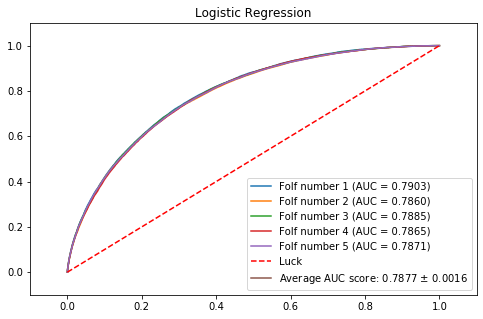

In [158]:
model = LogisticRegression(C=0.03, max_iter=300)

fig, ax = plt.subplots(figsize=(8,5))
aucs = []
cv = StratifiedKFold(n_splits=5, shuffle=True)

for i, (train,valid) in tqdm_notebook(enumerate(cv.split(encoded_train, raw_train.target))):
    
    model.fit(encoded_train[train], raw_train.target[train])
    valid_pred = model.predict_proba(encoded_train[valid])[:, 1]
    
    fpr, tpr, threshold = roc_curve(raw_train.target[valid], valid_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'Folf number {i+1} (AUC = {roc_auc:.4f})')
    aucs.append(roc_auc)

ax.plot([0,1], [0,1], label='Luck', linestyle='--', color='r')  
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
ax.plot(mean_auc, label=f'Average AUC score: {mean_auc:.4f} $\pm$ {std_auc:.4f}')
ax.legend(loc="lower right")
ax.set(xlim=[-.1, 1.1], ylim=[-.1, 1.1], title='Logistic Regression')
plt.show()

In [146]:
encoded_train[next(iter(cv.split(encoded_train, raw_train.target)))[0]]

<480000x5856 sparse matrix of type '<class 'numpy.float64'>'
	with 19490058 stored elements in Compressed Sparse Row format>

In [148]:
raw_train.target[next(iter(cv.split(encoded_train, raw_train.target)))[0]]

id
1         0
2         0
4         0
6         0
7         0
         ..
599991    0
599992    0
599993    0
599997    0
599998    0
Name: target, Length: 480000, dtype: int64

In [151]:
len(next(iter(cv.split(encoded_train, raw_train.target)))[1])

120000

In [152]:
raw_train.target

id
0         0
1         0
2         0
3         0
4         0
         ..
599995    0
599996    0
599997    0
599998    0
599999    0
Name: target, Length: 600000, dtype: int64

In [154]:
model.fit(encoded_train[next(iter(cv.split(encoded_train, raw_train.target)))[0]],raw_train.target[next(iter(cv.split(encoded_train, raw_train.target)))[0]])
#model.predict_proba(encoded_train[next(iter(cv.split(encoded_train, raw_train.target)))[1]])

LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [157]:
model.predict_proba(encoded_train[next(iter(cv.split(encoded_train, raw_train.target)))[1]])

array([[0.79877031, 0.20122969],
       [0.77568555, 0.22431445],
       [0.79984401, 0.20015599],
       ...,
       [0.7961282 , 0.2038718 ],
       [0.84782309, 0.15217691],
       [0.7917941 , 0.2082059 ]])

In [159]:
model = LogisticRegression(C=0.03, max_iter=300)
model.fit(encoded_train, raw_train.target)
test_pred = model.predict_proba(encoded_test)[:, 1]

In [164]:
test_pred[np.argmax(test_pred)]

0.9613815777671892

# Summary

In [3]:
train_path = 'train.csv'
test_path = 'test.csv'
sample_path = 'sample_submission.csv'

raw_train = pd.read_csv(train_path, index_col='id')
raw_test = pd.read_csv(test_path, index_col='id')
raw_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [4]:
#column의 수가 다른 두 df을 concat하면 차이나는 column들은 모두 NAN으로 채워진다.
#sort : column 이름의 사전순서
all_data = pd.concat([raw_train, raw_test],sort = False).drop(columns = 'target') #전처리할때는 일단 train, test둘다 합침.

In [5]:
# strategy : devide columns into catrgorical and numeric columns
# categorical columns
cate_cols = all_data.select_dtypes(include = ['object']).columns
for col in cate_cols:
    train_values = set(raw_train[col].unique())
    test_values = set(raw_test[col].unique())
    xor_values = train_values ^ test_values # train, test 둘다 가지고 있는 원소가 아니면 모두 'xor'로 대체.
    
    if xor_values:
        print(f'Replace {len(xor_values)} in {col} column')
        print('They are: ', xor_values)
        print()
        all_data.loc[all_data[col].isin(xor_values),col] = 'xor'

Replace 1 in nom_5 column
They are:  {'b3ad70fcb'}

Replace 4 in nom_6 column
They are:  {'ee6983c6d', 'f0732a795', 'a885aacec', '3a121fefb'}

Replace 2 in nom_9 column
They are:  {'3d19cd31d', '1065f10dd'}



In [6]:
all_data['ord_1'].unique()

array(['Contributor', 'Grandmaster', nan, 'Novice', 'Expert', 'Master'],
      dtype=object)

In [7]:
map_ord1 = {'Novice' : 1, 'Contributor' : 2, 'Expert' : 3, 'Master' : 4, 'Grandmaster' : 5}
all_data.ord_1 = all_data.ord_1.map(map_ord1)

In [8]:
all_data['ord_2'].unique()

array(['Hot', 'Warm', 'Freezing', 'Lava Hot', 'Cold', 'Boiling Hot', nan],
      dtype=object)

In [9]:
map_ord2 = {'Freezing' : 1, 'Cold' : 2, 'Warm' : 3, 'Hot' : 4, 'Boiling Hot' : 5, 'Lava Hot' : 6}
all_data.ord_2 = all_data.ord_2.map(map_ord2)

In [10]:
all_data['ord_3'].unique()

array(['c', 'e', 'n', 'a', 'h', 'b', 'd', 'k', 'g', 'o', 'i', 'm', nan,
       'f', 'l', 'j'], dtype=object)

In [11]:
all_data['ord_3'] = all_data.ord_3.map(ord, na_action = 'ignore') #알파벳 한개로 돼있는 것들은 ord 함수를 통해 ascii 코드로 변환.
map_ord3 = {key:value for value,key in enumerate(sorted(all_data.ord_3.dropna().unique()))}
all_data.ord_3 = all_data.ord_3.map(map_ord3)
all_data.ord_3.head()

id
0     2.0
1     4.0
2    13.0
3     0.0
4     7.0
Name: ord_3, dtype: float64

In [12]:
all_data['ord_4'].unique()

array(['U', 'X', 'P', 'C', 'Q', 'R', 'Y', 'N', 'I', 'O', 'M', 'E', 'V',
       'K', 'G', 'B', 'H', nan, 'T', 'W', 'A', 'F', 'D', 'S', 'J', 'L',
       'Z'], dtype=object)

In [13]:
all_data['ord_4'] = all_data.ord_4.map(ord, na_action = 'ignore')
map_ord4 = {key:value for value,key in enumerate(sorted(all_data.ord_4.dropna().unique()))}
all_data.ord_4 = all_data.ord_4.map(map_ord4)
all_data.ord_4.head()

id
0    20.0
1    23.0
2    15.0
3     2.0
4     2.0
Name: ord_4, dtype: float64

In [14]:
#알파벳이 2개로 돼있는 것들은 첫번째 알파벳, 두번째 알파벳으로 나눠서 ord를 통해 아스키코드를 구해서 각각 열을 추가.
all_data['ord_5_1'] = all_data.ord_5.map(lambda string:ord(string[0]), na_action = 'ignore')
all_data['ord_5_2'] = all_data.ord_5.map(lambda string:ord(string[1]), na_action = 'ignore')
map_ord5 = {key:value for value,key in enumerate(sorted(all_data.ord_5.dropna().unique()))}
all_data.ord_5 = all_data.ord_5.map(map_ord5)

In [15]:
#숫자 열, catrgorical 변환 열 나누기.
num_cols = all_data.select_dtypes(exclude = ['object']).columns.drop(['bin_0', 'bin_1', 'bin_2'])
cate_cols = all_data.columns.drop(num_cols)

In [16]:
#missing value columns(numeric columns only)
missing_cols = [col for col in num_cols if any(all_data[col].isnull())]
missing_cols

['ord_0',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5',
 'day',
 'month',
 'ord_5_1',
 'ord_5_2']

In [17]:
for col in missing_cols:
    all_data[col + ' : missing'] = all_data[col].isnull().astype(int)

In [18]:
# 요일과 달(시간)에 대한 정보를 담고있는 열은 따로 추출해서 normalization하고 2pi를 곱해서 sin, cos을 씌움.
time_cols = ['day', 'month']
for col in time_cols:
    all_data[col+'_sin'] = np.sin(2 * np.pi * all_data[col] / 7)
    all_data[col+'_cos'] = np.cos(2 * np.pi * all_data[col] / 12)
all_data = all_data.drop(columns = time_cols)

In [19]:
retain_cols = [f'ord_{i}' for i in range(6)] + ['day_sin', 'day_cos', 'month_sin', 'month_cos'] #ont hot을 하지않는 열
OH_cols = all_data.columns#one hot을 통해 변경해야 하는 열

#get_dummies : data의 조합에 대한 ont-hot encoding 조합을 모두 나열해줌.
all_OH = pd.get_dummies(all_data,
                        columns = OH_cols,
                        dummy_na=True,
                        sparse=True,
                        drop_first=True).sparse.to_coo()

In [20]:
#변형
#retain_cols = [f'ord_{i}' for i in range(6)] + ['day_sin', 'day_cos', 'month_sin', 'month_cos'] #ont hot을 하지않는 열
retain_cols = [f'ord_{i}' for i in range(6)] + ['ord_5_1','ord_5_2','day_sin', 'day_cos', 'month_sin', 'month_cos'] #ont hot을 하지않는 열
OH_cols = all_data.columns.drop(retain_cols) #one hot을 통해 변경해야 하는 열

#get_dummies : data의 조합에 대한 ont-hot encoding 조합을 모두 나열해줌.
all_OH = pd.get_dummies(all_data[OH_cols],
                        columns = OH_cols,
                        dummy_na=True, #one hot encoding을 통해 na처리
                        sparse=True,
                        drop_first=True).sparse.to_coo()

In [21]:
all_data.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'ord_5_1', 'ord_5_2',
       'ord_0 : missing', 'ord_1 : missing', 'ord_2 : missing',
       'ord_3 : missing', 'ord_4 : missing', 'ord_5 : missing',
       'day : missing', 'month : missing', 'ord_5_1 : missing',
       'ord_5_2 : missing', 'day_sin', 'day_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [22]:
OH_cols

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0 : missing', 'ord_1 : missing', 'ord_2 : missing',
       'ord_3 : missing', 'ord_4 : missing', 'ord_5 : missing',
       'day : missing', 'month : missing', 'ord_5_1 : missing',
       'ord_5_2 : missing'],
      dtype='object')

In [23]:
#Imputation transformer for completing missing values. -> ont hot 안하는 것들은 imputer를 통해 na처리.
imputer = SimpleImputer() # strategy = 'mean' : default
retain_all = pd.DataFrame(imputer.fit_transform(all_data[retain_cols]), columns = retain_cols)
retain_all

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,ord_5_1,ord_5_2,day_sin,day_cos,month_sin,month_cos
0,3.0,2.000000,4.000000,2.0,20.0,56.000000,80.000000,119.00000,-7.818315e-01,-1.000000e+00,4.338837e-01,6.123234e-17
1,3.0,5.000000,3.000000,4.0,23.0,150.000000,112.000000,69.00000,-2.449294e-16,-8.660254e-01,-2.449294e-16,-8.660254e-01
2,3.0,2.720606,1.000000,13.0,15.0,105.000000,101.000000,78.00000,-9.749279e-01,-8.660254e-01,9.749279e-01,-1.836970e-16
3,1.0,1.000000,6.000000,0.0,2.0,91.013228,92.693774,92.21149,4.338837e-01,6.123234e-17,4.338837e-01,6.123234e-17
4,3.0,5.000000,2.000000,7.0,2.0,50.000000,79.000000,90.00000,-9.749279e-01,-8.660254e-01,-9.749279e-01,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2.0,3.000000,3.000000,13.0,17.0,103.000000,100.000000,112.00000,9.749279e-01,5.000000e-01,-9.749279e-01,1.000000e+00
999996,1.0,2.000000,3.083473,13.0,23.0,79.000000,85.000000,83.00000,7.818315e-01,8.660254e-01,-9.749279e-01,-8.660254e-01
999997,1.0,5.000000,5.000000,12.0,15.0,73.000000,84.000000,76.00000,7.818315e-01,8.660254e-01,-7.818315e-01,-1.000000e+00
999998,3.0,1.000000,6.000000,7.0,11.0,11.000000,68.000000,73.00000,9.749279e-01,5.000000e-01,-4.338837e-01,8.660254e-01


In [24]:
#nomalization
retain_all = retain_all/retain_all.max()
retain_all

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,ord_5_1,ord_5_2,day_sin,day_cos,month_sin,month_cos
0,1.000000,0.400000,0.666667,0.142857,0.80,0.296296,0.655738,0.975410,-8.019377e-01,-1.154701e+00,4.450419e-01,6.123234e-17
1,1.000000,1.000000,0.500000,0.285714,0.92,0.793651,0.918033,0.565574,-2.512282e-16,-1.000000e+00,-2.512282e-16,-8.660254e-01
2,1.000000,0.544121,0.166667,0.928571,0.60,0.555556,0.827869,0.639344,-1.000000e+00,-1.000000e+00,1.000000e+00,-1.836970e-16
3,0.333333,0.200000,1.000000,0.000000,0.08,0.481551,0.759785,0.755832,4.450419e-01,7.070502e-17,4.450419e-01,6.123234e-17
4,1.000000,1.000000,0.333333,0.500000,0.08,0.264550,0.647541,0.737705,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.666667,0.600000,0.500000,0.928571,0.68,0.544974,0.819672,0.918033,1.000000e+00,5.773503e-01,-1.000000e+00,1.000000e+00
999996,0.333333,0.400000,0.513912,0.928571,0.92,0.417989,0.696721,0.680328,8.019377e-01,1.000000e+00,-1.000000e+00,-8.660254e-01
999997,0.333333,1.000000,0.833333,0.857143,0.60,0.386243,0.688525,0.622951,8.019377e-01,1.000000e+00,-8.019377e-01,-1.000000e+00
999998,1.000000,0.200000,1.000000,0.500000,0.44,0.058201,0.557377,0.598361,1.000000e+00,5.773503e-01,-4.450419e-01,8.660254e-01


In [25]:
encoded_all = scipy.sparse.hstack([all_OH, retain_all, retain_all**2]).tocsr()
encoded_all.shape

(1000000, 5477)

In [26]:
encoded_train = encoded_all[:len(raw_train)]
encoded_test = encoded_all[len(raw_train):]

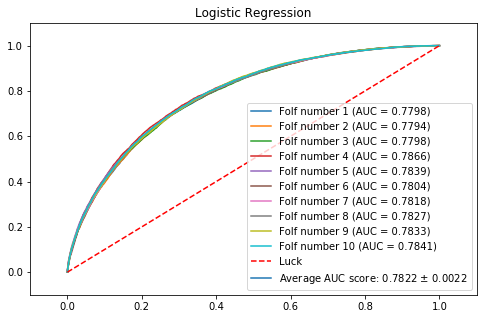

In [27]:
model = LogisticRegression(C=0.03, max_iter=300)

fig, ax = plt.subplots(figsize=(8,5))
aucs = []
cv = StratifiedKFold(n_splits=10, shuffle=True)

for i, (train,valid) in tqdm_notebook(enumerate(cv.split(encoded_train, raw_train.target))):
    
    model.fit(encoded_train[train], raw_train.target[train])
    valid_pred = model.predict_proba(encoded_train[valid])[:, 1]
    
    fpr, tpr, threshold = roc_curve(raw_train.target[valid], valid_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'Folf number {i+1} (AUC = {roc_auc:.4f})')
    aucs.append(roc_auc)

ax.plot([0,1], [0,1], label='Luck', linestyle='--', color='r')  
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
ax.plot(mean_auc, label=f'Average AUC score: {mean_auc:.4f} $\pm$ {std_auc:.4f}')
ax.legend(loc='best')
ax.set(xlim=[-.1, 1.1], ylim=[-.1, 1.1], title='Logistic Regression')
plt.show()

In [31]:
model = LogisticRegression(C=0.03, max_iter=300)
model.fit(encoded_train, raw_train.target)
test_pred = model.predict_proba(encoded_test)[:, 1] # probability between 0 and 1
#test_pred = model.predict(encoded_test) # only 0 or 1

In [34]:
np.max(test_pred)

1

In [74]:
subsample = pd.read_csv(sample_path)
subsample.head()

,id,target
0,600000,0.5
1,600001,0.5
2,600002,0.5
3,600003,0.5
4,600004,0.5


In [35]:
sub = pd.DataFrame({'id' : raw_test.index, 'target' : test_pred})
sub.head()

,id,target
0,600000,0
1,600001,0
2,600002,0
3,600003,0
4,600004,0


In [36]:
#sub.to_csv('cat_in_the_dat_predict.csv', index = False)

In [37]:
org = pd.read_csv('cat_in_the_dat.csv')
div = pd.read_csv('cat_in_the_dat_division.csv')
prd = pd.read_csv('cat_in_the_dat_predict.csv')

In [38]:
org.head()

,id,target
0,600000,0.125373
1,600001,0.252173
2,600002,0.153750
3,600003,0.110575
4,600004,0.124334


In [39]:
div.head()

,id,target
0,600000,0.068246
1,600001,0.204136
2,600002,0.143672
3,600003,0.111330
4,600004,0.147843


In [40]:
prd.head()

,id,target
0,600000,0
1,600001,0
2,600002,0
3,600003,0
4,600004,0


In [41]:
predo = org['target']
predd = div['target']
predp = prd['target']

In [42]:
np.max(predo), np.max(predd), np.max(predp)

(0.9613815777671892, 0.9559420477478942, 1)

In [43]:
np.min(predo), np.min(predd), np.min(predp)

(0.0008448235354427281, 0.0011789128148214873, 0)

In [52]:
predo[predd >= 0.5]

6         0.643364
35        0.436072
45        0.734866
70        0.697811
150       0.563370
            ...   
399974    0.565633
399981    0.763655
399984    0.530778
399993    0.662547
399995    0.587160
Name: target, Length: 23628, dtype: float64

In [51]:
predp[predp == 1]

6         1
35        1
45        1
70        1
150       1
         ..
399974    1
399981    1
399984    1
399993    1
399995    1
Name: target, Length: 23592, dtype: int64

In [54]:
np.argmax(predp)

6

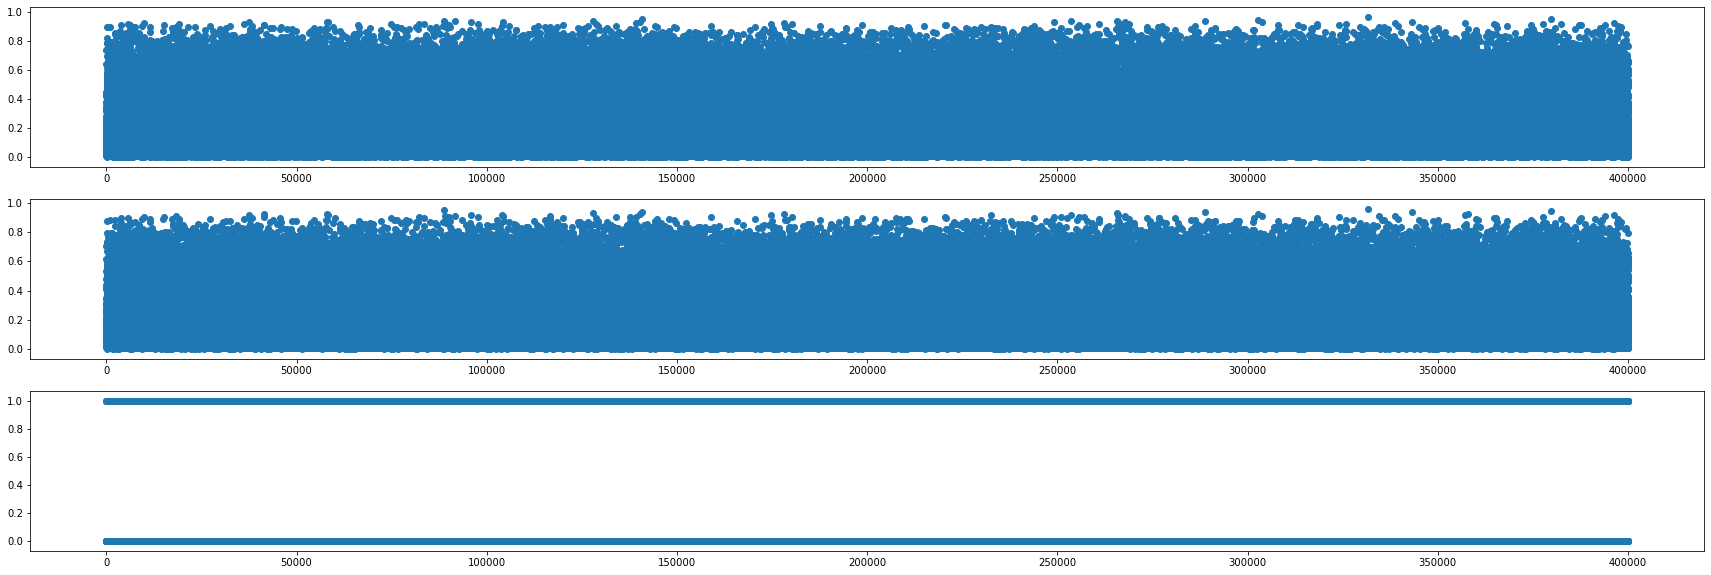

In [55]:
plt.figure(figsize = (30,10))
plt.subplot(311)
plt.scatter(range(len(predo)),predo)

plt.subplot(312)
plt.scatter(range(len(predd)),predd)

plt.subplot(313)
plt.scatter(range(len(predp)),predp)
plt.show()

In [86]:
len(predo)

400000

In [87]:
np.mean(predo), np.std(predo)

(0.1872908210785396, 0.1634791646329324)

In [88]:
np.mean(predd), np.std(predd)

(0.18724423825962302, 0.15929799321005786)